In [382]:
import glob
import os
import pandas as pd
import numpy as np

def read_proxy_test(directory, max_simul):
    means, low, high = [], [], []
    for i in range(1, max_simul+1):
        f = os.path.join(directory, 'simul_%d.txt'%i)
        df = pd.read_csv(f, names=('client', 'i', 'time'))
        means.append(np.percentile(df.time, 50))
        low.append(np.percentile(df.time, 1))
        high.append(np.percentile(df.time, 99))
    return np.array(means)*1e3, np.array(low)*1e3, np.array(high)*1e3
        
# y, err = read_proxy_test("proxy_tests/tsproxy", 50)
sl2 = read_proxy_test("proxy_tests/eb_tsproxy", 200)



In [417]:
noproxy = read_proxy_test('proxy_tests/noproxy', 200)

In [414]:
sl1 = read_proxy_test('proxy_tests/slproxy_1', 200)

In [415]:
ha1_mc = read_proxy_test('proxy_tests/haproxy_1_mc', 200)

In [467]:
ha1 = read_proxy_test('proxy_tests/haproxy_1a', 200)

In [468]:
ha2 = read_proxy_test("proxy_tests/haproxy_2a", 200)

In [319]:
ha2_mc = read_proxy_test("proxy_tests/haproxy_2_mc", 200)

In [289]:
sl2 = read_proxy_test("proxy_tests/slproxy_2", 200)

In [471]:
ha3 = read_proxy_test('proxy_tests/haproxy_3a', 200)

In [303]:
ha3_mc = read_proxy_test('proxy_tests/haproxy_3_mc', 200)

In [287]:
sl3 = read_proxy_test('proxy_tests/slproxy_3', 200)

In [473]:
ha4 = read_proxy_test('proxy_tests/haproxy_4', 200)

In [474]:
ha4_mc = read_proxy_test('proxy_tests/haproxy_4_mc', 200)

In [475]:
sl4 = read_proxy_test('proxy_tests/slproxy_4', 200)

In [249]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
sns.set_style('whitegrid')

<IPython.core.display.Javascript object>


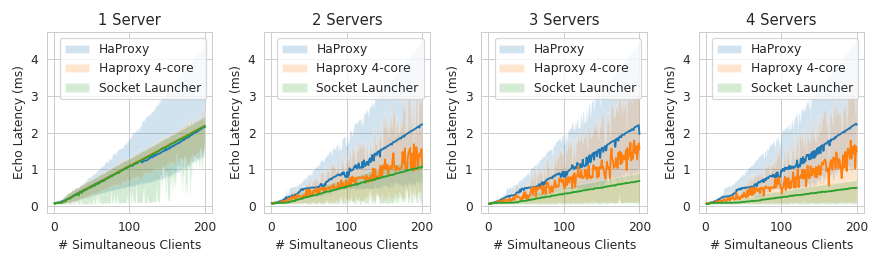

In [482]:
def make_proxy_latency_plot(series, labels = ['HaProxy', 'Socket Launcher'], baseline=None, ):
    handles = []
    for serie in series:
        m, l, h = serie
        if baseline is not None:
            m = m - baseline[:len(m)]
            l = l - baseline[:len(m)]
            h = h - baseline[:len(m)]
        x = range(1, len(m) + 1)
        plt.plot(x, m)
        handles.append(plt.fill_between(x, l, h, alpha=.2))

    plt.xlabel("# Simultaneous Clients")
    if baseline is None:
        plt.ylabel("Echo Latency (ms)")
    else:
        plt.ylabel("Latency over baseline (ms)")

    plt.legend(labels=labels, handles=handles)

plt.figure(figsize=(10,3))
ax = plt.subplot(141)
make_proxy_latency_plot([ha1, ha1_mc, sl1], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher', 'No Proxy'],)
#                         noproxy[0])
plt.title("1 Server")
plt.subplot(142, sharey=ax)
make_proxy_latency_plot([ha2, ha2_mc, sl2], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/2)
plt.title("2 Servers")
plt.subplot(143, sharey=ax)
make_proxy_latency_plot([ha3, ha3_mc, sl3], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/3)
plt.title("3 Servers")
plt.subplot(144, sharey=ax)
make_proxy_latency_plot([ha4, ha4_mc, sl4], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/4)
plt.title("4 Servers")

plt.tight_layout()

In [484]:
import json
def read_iperf_proxy_test(directory, max_simul):
    means, low, high = [], [], []
    for i in range(1, max_simul+1):
        f = os.path.join(directory, 'simul_%d.txt'%i)
        results = json.load(open(f))
        bps = []
        for interval in results['intervals'][10:]:
            bps.append(interval['sum']['bits_per_second'])
        means.append(sum(bps) / len(bps))
        low.append(min(bps))
        high.append(max(bps))
    return np.array(means) * 1e-9, np.array(low) * 1e-9, np.array(high)*1e-9

iperf_ha = read_iperf_proxy_test('proxy_tests/iperf_haproxy_3', 100)
iperf_ha_mc = read_iperf_proxy_test('proxy_tests/iperf_haproxy_mc', 100)
iperf_ts = read_iperf_proxy_test('proxy_tests/iperf_slproxy_short', 100)
iperf_no = read_iperf_proxy_test('proxy_tests/iperf_noproxy', 100)

ZeroDivisionError: integer division or modulo by zero

<IPython.core.display.Javascript object>


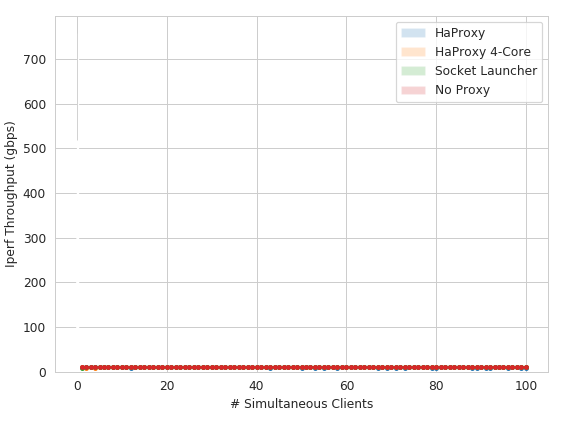

In [483]:
def make_proxy_plot(series, labels, dec10=False):
    handles = []
    for serie in series:
        y1, l1, h1 = serie
        if dec10:
            y1 = (10-y1)
            l1 = (10-l1)
            h1 = (10-h1)
        x = range(1, len(y1)+1)
        plt.plot(x, y1, '.-')
        handles.append(plt.fill_between(x, l1, h1, alpha=.2))

    plt.xlabel("# Simultaneous Clients")
    if not dec10:
        plt.ylabel("Iperf Throughput (gbps)")
    else:
        plt.ylabel("Iperf Throughput Loss (gbps)")
            
    # plt.yscale('log')

    plt.legend(labels=labels, handles=handles)
    
plt.figure()
make_proxy_plot([iperf_ha, iperf_ha_mc, iperf_ts, iperf_no], ['HaProxy', 'HaProxy 4-Core', 'Socket Launcher', 'No Proxy'])
plt.tight_layout()

In [588]:
def read_xfer_test(test_file, xfer_interval):
    xmeans, xlow, xhigh = [], [], []
    nmeans, nlow, nhigh = [], [], []
    f = open(test_file)
    df = pd.read_csv(f, names=('client', 'i', 'time'))
    
    df.time *= 1e3
    
    xfers = df[((df.i) % xfer_interval) == 0]
    nfers = df[((df.i) % xfer_interval) != 0]
    
    return xfers, nfers

x, n = read_xfer_test('xfer_data/pre_response_10_0.csv', 10)

In [591]:
x.time

0         0.224
10      209.044
20      208.692
30      210.852
40      208.756
50      210.996
60      208.742
70      210.993
80      208.807
90      211.022
100     208.726
110     210.829
120     208.716
130     210.802
140     208.717
150     210.817
160     208.747
170     210.816
180     208.732
190     210.844
200     208.727
210     210.831
220     208.716
230     210.826
240     208.760
250     210.786
260     208.764
270     210.834
280     208.736
290     210.827
         ...   
1700    208.701
1710    210.893
1720    208.717
1730    210.834
1740    208.699
1750    210.896
1760    208.703
1770    210.863
1780    208.702
1790    210.847
1800    208.818
1810    210.750
1820    208.753
1830    210.785
1840    208.730
1850    210.747
1860    208.694
1870    210.811
1880    208.681
1890    210.775
1900    208.696
1910    210.814
1920    208.713
1930    210.775
1940    208.734
1950    210.782
1960    208.751
1970    210.794
1980    208.717
1990    210.808
Name: time, Length: 200,

In [584]:
n['idx'] = n.i % 10

<IPython.core.display.Javascript object>


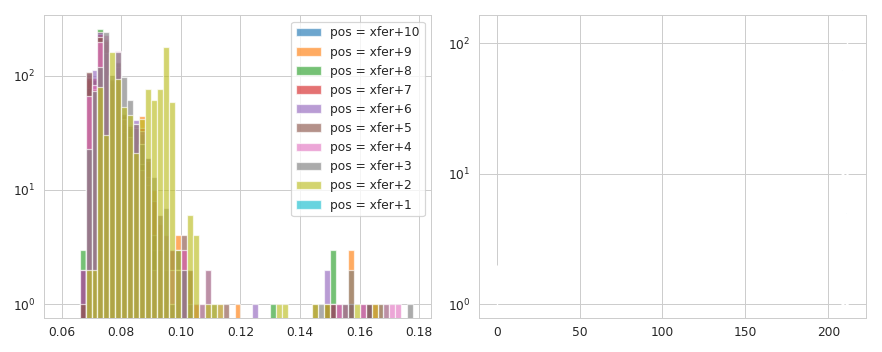

In [585]:
plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(10)[::-1]:
    plt.hist(n[n.idx == i].time,bins=np.arange(0.06, .18, .002), label='pos = xfer+%d' % (i+1), alpha=.65)
plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.hist(x.time, bins=np.arange(min(x.time), max(x.time), .05))
plt.yscale('log')
plt.tight_layout()


In [587]:
x.time

0         0.218
10        0.220
20        0.112
30      208.970
40      208.277
50      210.907
60      208.375
70      210.977
80      208.250
90      211.045
100     208.464
110     210.954
120     208.373
130     211.028
140     208.255
150     210.935
160     212.201
170     210.986
180     208.322
190     210.920
200     208.363
210     210.881
220     208.445
230     210.924
240     208.280
250     211.051
260     208.541
270     211.243
280     208.444
290     211.259
         ...   
9700    208.464
9710    211.240
9720    208.673
9730    211.312
9740    208.435
9750    211.245
9760    208.662
9770    211.340
9780    208.637
9790    211.234
9800    208.618
9810    211.296
9820    208.674
9830    211.248
9840    208.628
9850    211.353
9860    208.710
9870    211.301
9880    208.670
9890    211.280
9900    208.659
9910    211.235
9920    208.600
9930    211.344
9940    208.684
9950    211.173
9960    208.567
9970    211.294
9980    208.698
9990    211.228
Name: time, Length: 1000

<IPython.core.display.Javascript object>


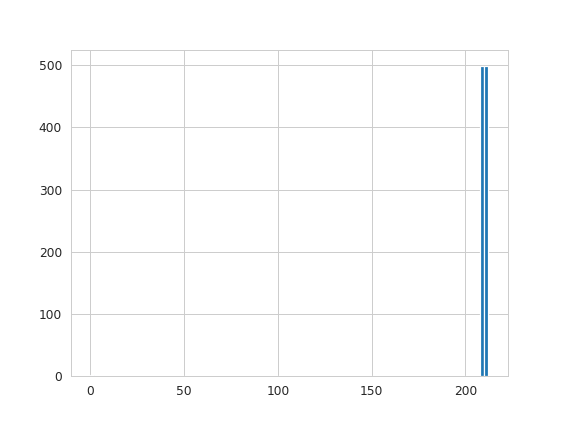

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 498.,
        499.]),
 array([1.1200000e-01, 2.2328900e+00, 4.3537800e+00, 6.4746700e+00,
        8.5955600e+00, 1.0716450e+01, 1.2837340e+01, 1.4958230e+01,
        1.7079120e+01, 1.9200010e+01, 2.1320900e+01, 2.3441790e+01,
        2.5562680e+01, 2.7683570e+01, 2.9804460e+01, 3.1925350e+01,
        3.4046240e+01, 3.6167130e+01, 3.828802

In [586]:
plt.figure()
plt.hist(x.time, 100)
